In [1]:
import os, sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import MaaSSim

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#!pip install MaaSSim
import MaaSSim.utils
import logging
from dotmap import DotMap
import MaaSSim.simulators
from MaaSSim.data_structures import structures as inData
from MaaSSim.day_to_day import S_driver_opt_out, S_traveller_opt_out, d2d_kpi_veh, d2d_kpi_pax

from MaaSSim.decisions import dummy_False

In [4]:
import osmnx as ox
import networkx as nx
import random
import math
import pandas as pd
import matplotlib.pyplot as plt          
import numpy as np
import seaborn as sns

In [5]:
# the setting for TRB results do not delete
params = MaaSSim.utils.get_config('glance.json')
params.city = "Amsterdam, Netherlands"
params.paths.G = "../../data/graphs/Amsterdam.graphml"
params.paths.skim = "../../data/graphs/Amsterdam.csv"
params.vehicle_fixed_positions = True
params.times.patience = 600 #second
params.dist_threshold = 20000 #meter
params.dist_threshold_min = 3000 #meter

params.d2d.probabilistic = True
params.d2d.heterogeneous = False
params.d2d.notification_via_marketing = False # If True, marketing is active and agents regularly get notified.
params.d2d.ini_att = 0.01 #0.5
params.d2d.B_income = 1
params.d2d.fuel_cost = 0.25 #euro/km

params.d2d.B_inveh_time = 1
params.d2d.B_exp_time = 2 #1.5 in oded's paper
params.PT_fare = 1 ## euro
params.PT_avg_speed = 6

params.nPM = 1 # number of platforms. platform id starts from 1
params.platforms.base_fare = 1.4 #euro
params.platforms.fare = float(1.20) #euro/km
params.platforms.min_fare = float(2) # euro
params.platforms.comm_rate = float(0.20)
params.platforms.discount = float(0.0) # float(0.0)
params.platforms.daily_marketing = False

params.d2d.learning_d = 1 #for TRB 
params.d2d.B_Experience = 0.80
params.d2d.B_WOM = 0.2
params.d2d.B_Marketing = 0.0
params.d2d.diffusion_speed = 10/100 # speed for M is twice greater than WOM.
params.d2d.m = 5 #for TRB
params.d2d.Eini_att = 0.01
params.d2d.adj_s = 2
params.VoT = 10.63 # value of time per hour
params.seed = 1
params.assert_me = False
params.paths.requests = 'Amsterdam_requests.csv'

params.lr = 0.0001 # input
params.stp = 0.01 # input
params.batch_size = 16

params.nP = 2000
params.nV = 200
params.nD = 1000
params.simTime = 4
params.d2d.res_wage = params.simTime*10.63 #euro

In [6]:
# Three changes in the setting based on the comments from Reviewers and supervisors:
# 1. we fix the demand, so travellers are always present and they don't choose between platform and PT
# 2. we fix the commission rate to 20% for baseline scenario to be inline with actual Uber operation 
# 3. we delete the greed stage from the baseline scenario to be inline with actual Uber operation 

In [ ]:
# sim = MaaSSim.simulators.simulate(params=params, f_driver_out=S_driver_opt_out,f_trav_out=dummy_False,
#                                   kpi_veh=d2d_kpi_veh,kpi_pax=d2d_kpi_pax, logger_level=logging.WARNING)

sim, agent_new = MaaSSim.simulators.simulate_RL_main(input_agent=None,params=params, f_driver_out=S_driver_opt_out,f_trav_out=S_traveller_opt_out,
                                  kpi_veh=d2d_kpi_veh,kpi_pax=d2d_kpi_pax, logger_level=logging.WARNING)

# sim, agent_new = MaaSSim.simulators.simulate_RL_main(input_agent=None,params=params, f_driver_out=dummy_False,f_trav_out=dummy_False,
#                                   kpi_veh=d2d_kpi_veh,kpi_pax=d2d_kpi_pax, logger_level=logging.WARNING)

This simulation uses albatros data
27-02-24 12:54:22-WARNING-Setting up 4h simulation at 2024-02-27 10:53:57 for 200 vehicles and 2000 passengers in Amsterdam, Netherlands
27-02-24 12:54:22-WARNING-`lr` is deprecated in Keras optimizer, please use `learning_rate` or use the legacy optimizer, e.g.,tf.keras.optimizers.legacy.Adam.
initialization-----------------------
state_size =  3   action_size =  3   bs =  16   step_size =  0.01   lr =  0.0001   Lever = Commission
fare =  1.2   comm_rate =  0.0   disc =  0.0   marketing = 0-100
-------------------------------------
Day =  0
27-02-24 12:54:31-WARNING-simulation time 2.5 s
nP =  0   nV =  0   comm_rate =  0.2   reward= 0.0
Day =  1
27-02-24 12:54:43-WARNING-simulation time 6.2 s
nP =  143   nV =  13   comm_rate =  0.2   reward= 225.48152
Day =  2
27-02-24 12:54:56-WARNING-simulation time 5.7 s
nP =  156   nV =  13   comm_rate =  0.2   reward= 238.51832
Day =  3
27-02-24 12:55:09-WARNING-simulation time 5.9 s
nP =  153   nV =  21   comm

In [16]:
params.nD = len(sim.res)

df_s = pd.DataFrame()
df_d = pd.DataFrame()

for d in range(0,params.nD):
    
    pax_exp = sim.res[d].pax_exp
    df_d.at[d, 'EXPERIENCE_U'] = pax_exp.EXPERIENCE_U.mean()
    df_d.at[d, 'WOM_U'] = pax_exp.WOM_U.mean()
    df_d.at[d, 'MARKETING_U'] = pax_exp.MARKETING_U.mean()
    df_d.at[d, 'OUT'] = pax_exp.OUT.value_counts().get(False, 0)
    
    veh_exp = sim.res[d].veh_exp
    df_s.at[d, 'EXPERIENCE_U'] = veh_exp.EXPERIENCE_U.mean()
    df_s.at[d, 'WOM_U'] = veh_exp.WOM_U.mean()
    df_s.at[d, 'MARKETING_U'] = veh_exp.MARKETING_U.mean()
    df_s.at[d, 'OUT'] = veh_exp.OUT.value_counts().get(False, 0)
    
    
    ld = sim.res[0].pax_exp.columns.values.tolist()
    ldn = [i for i in ld if i not in ['EXPERIENCE_U', 'WOM_U', 'MARKETING_U', 'OUT']]
    for col in ldn:
        df_d.at[d, col] = pax_exp[pax_exp.OUT==False][col].mean()
        
    ls = sim.res[0].veh_exp.columns.values.tolist()
    lsn = [i for i in ls if i not in ['EXPERIENCE_U', 'WOM_U', 'MARKETING_U', 'OUT']]
    for col in lsn:
        df_s.at[d, col] = veh_exp[veh_exp.OUT==False][col].mean()


run_id = 5 # input
df_d.to_csv('csv/demand_run_{}.csv'.format(run_id))
df_s.to_csv('csv/supply_run_{}.csv'.format(run_id))
sim.RL.to_csv('csv/rl_run_{}.csv'.format(run_id))

<AxesSubplot:ylabel='comm_rate'>

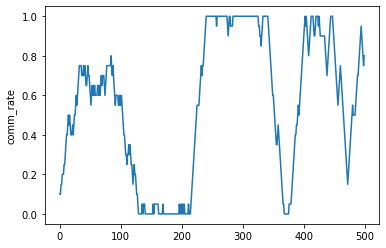

In [28]:
df = pd.read_csv('csv/rl_run_4.csv')

sns.lineplot(x=df.index , y=df.comm_rate)

In [13]:
df_d = pd.read_csv('csv/demand_run_1.csv')
df_s = pd.read_csv('csv/supply_run_1.csv')

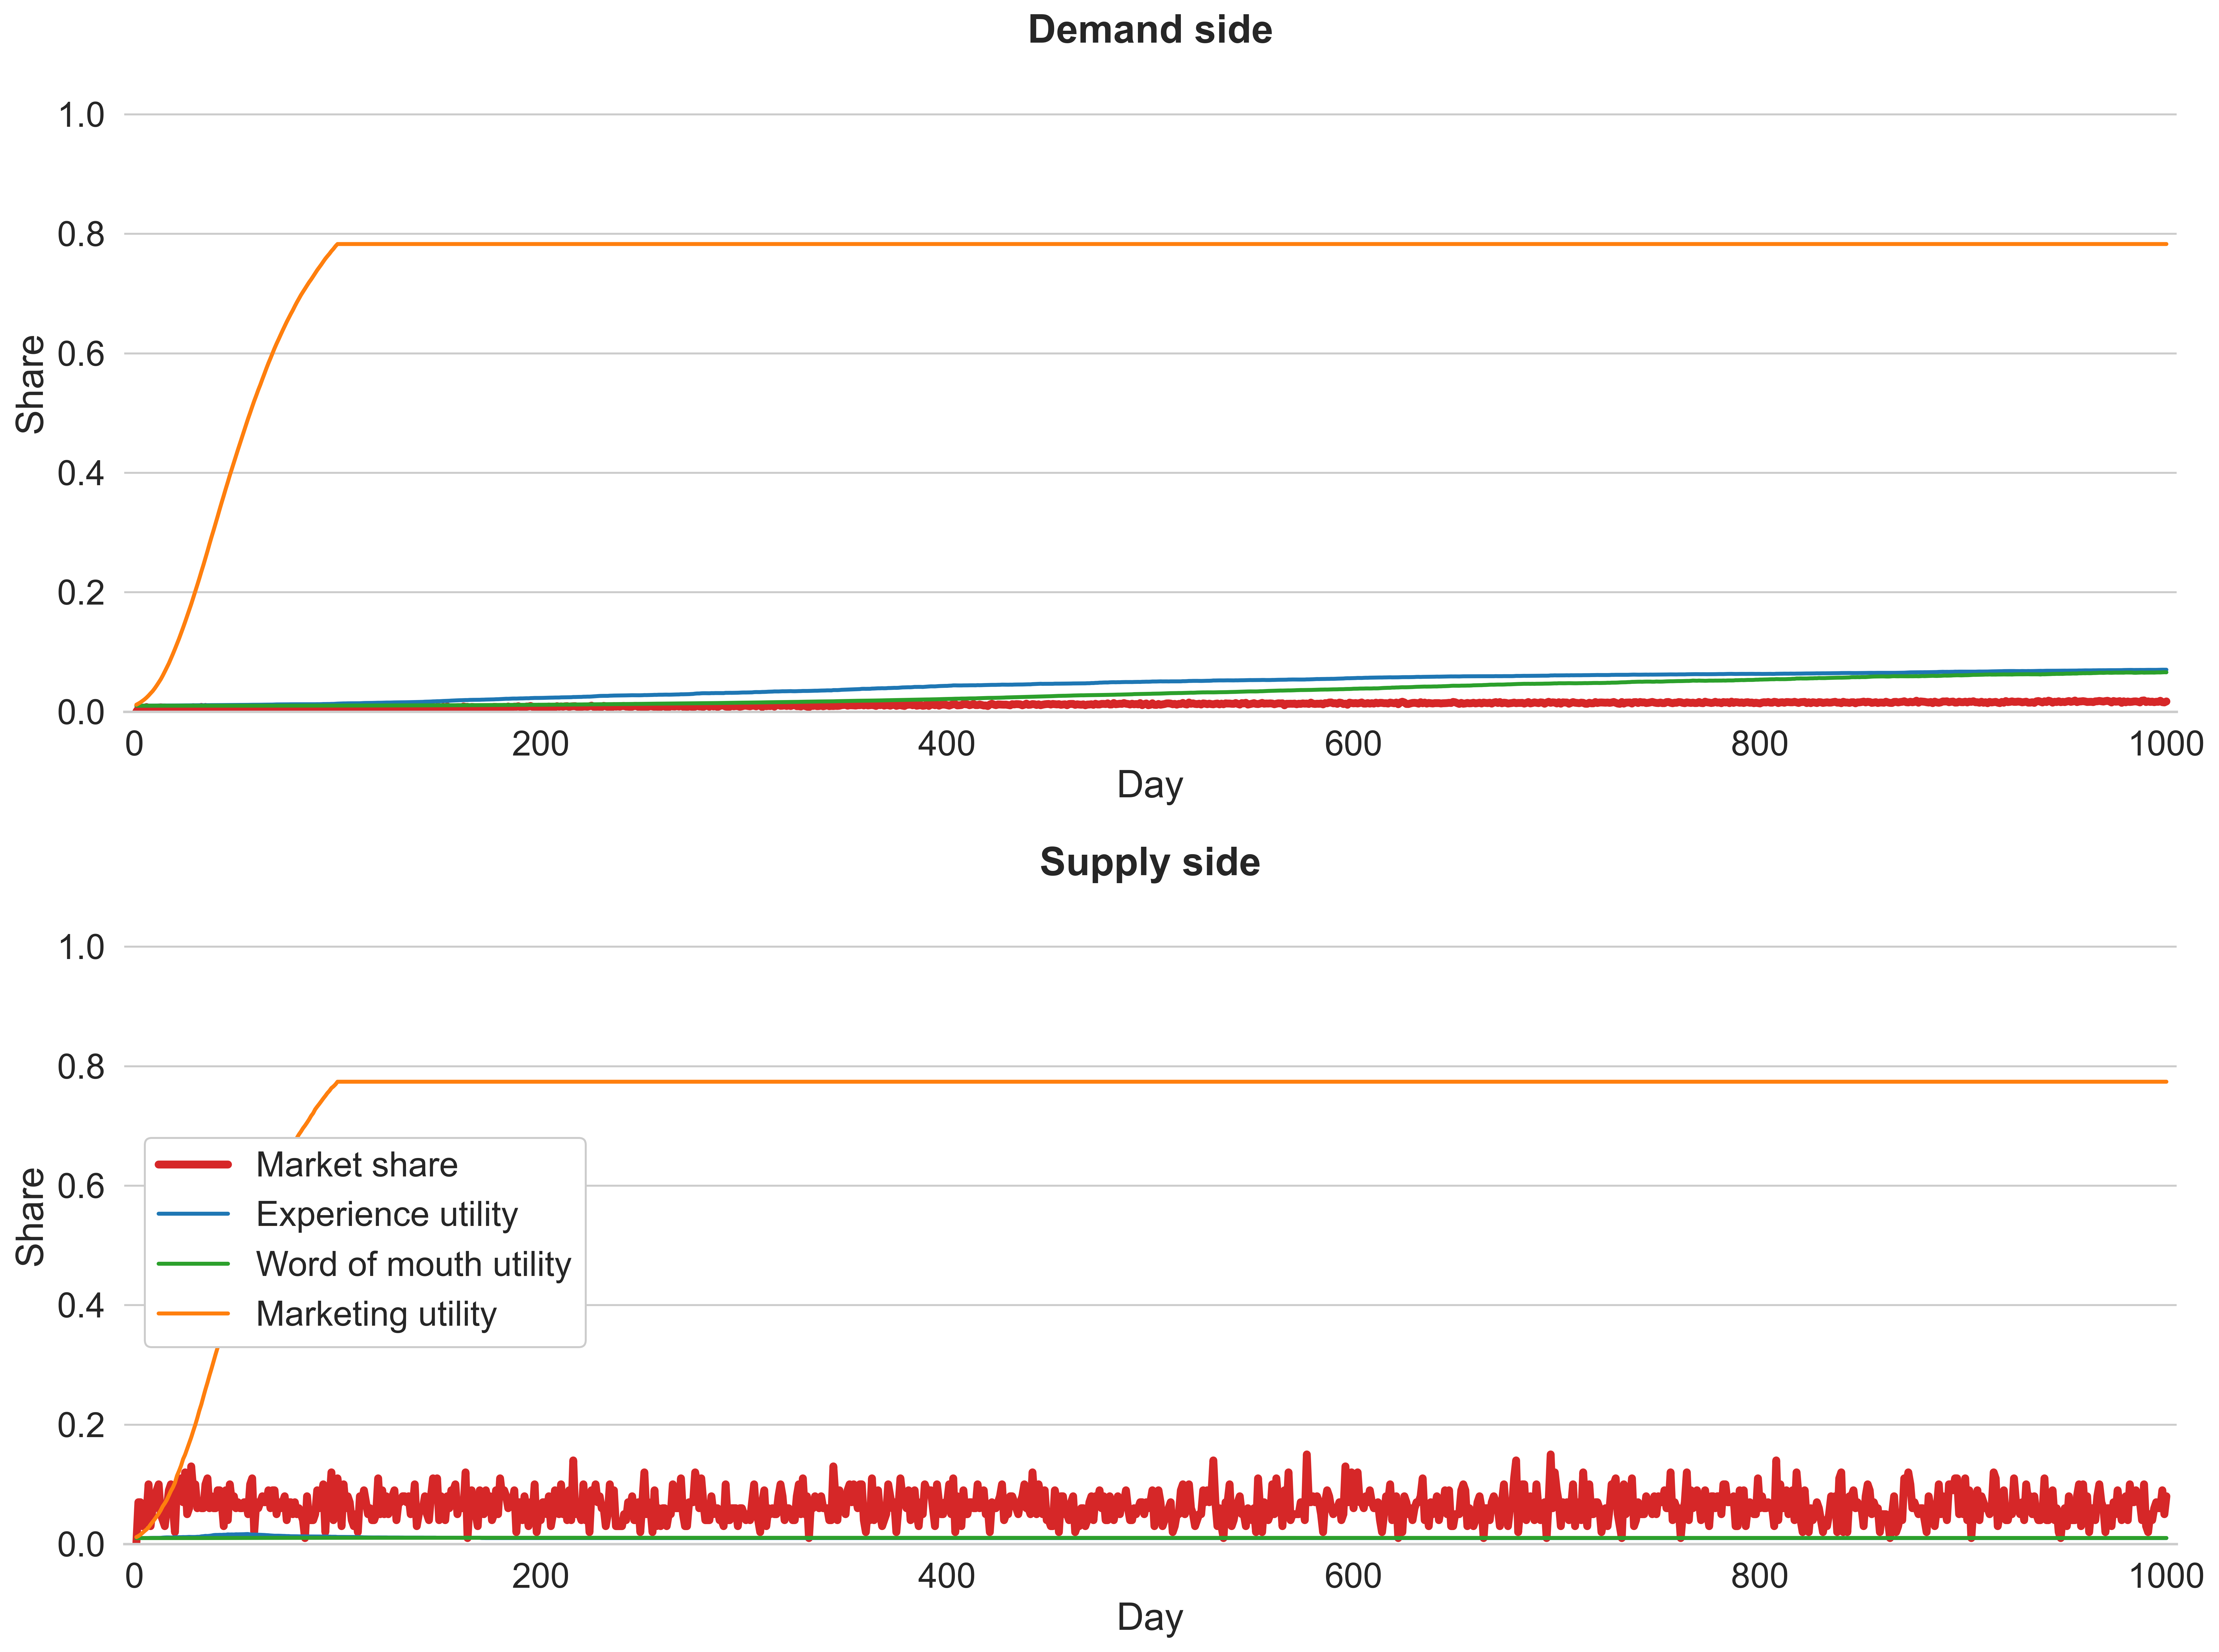

In [14]:
# np 10000, nv 1000, fare 1.2 euro, simtime 4, .d2d.m = 7

sns.set(rc={"figure.dpi":500, 'savefig.dpi':500})
sns.set(palette='tab10',font_scale=1.6)#, rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'},)
sns.set_style('whitegrid')
fig, ax = plt.subplots(nrows=2, figsize=(16,12))
# plt.subplots_adjust(wspace=0.3, hspace=0.4)
sns.despine(left=True)
params.nD=1000
params.nP=10000
params.nV=100
for row in range(0,2):
    
    if row==0:
        df=df_d; n=params.nP; label='Demand side'
    elif row==1:
        df = df_s; n = params.nV; label='Supply side'
        
    lx = [i for i in range(1,params.nD+1)]
    sns.lineplot(x=lx, y=df.OUT/n, label = 'Market share', color='C3', lw=4, ax=ax[row])
    sns.lineplot(x=lx, y=df.EXPERIENCE_U, label = 'Experience utility', color='C0', lw=2, ax=ax[row])
    sns.lineplot(x=lx, y=df.WOM_U, label = 'Word of mouth utility', color='C2', lw=2, ax=ax[row])
    sns.lineplot(x=lx, y=df.MARKETING_U, label = 'Marketing utility', color='C1', lw=2, ax=ax[row])

    ax[row].grid(axis='x')
    ax[row].set(xlabel='Day', ylabel='Share', ylim=(0,1.1),  xlim=(-5,params.nD+5))
    ax[row].set_title(label,fontweight='bold', loc='center',fontsize=20)

ax[1].legend(frameon=True,framealpha=1, loc=(0.01,0.3))#,  bbox_to_anchor=(0.75, 1.24), ncol=4)
ax[0].get_legend().set_visible(False)
# ax[ax_n].vlines([25, 50, 100, 200, 300], 0, 1.1, linestyles='dashed', colors='black')
# for i in range(0,6):
#     value = ['I','II','III','IV','V','VI']
#     coords = [(12,1.05),(36,1.05),(74,1.05),(149,1.05),(249,1.05),(349,1.05)]
#     ax[0].annotate(value[i], xy =coords[i], fontweight='bold')

# plt.yticks([0,1])

plt.tight_layout()

In [31]:
df.working_U

0           NaN
1     -0.400000
2      0.010703
3      0.011801
4      0.011921
         ...   
995    0.010022
996    0.010023
997    0.010029
998    0.010028
999    0.010031
Name: working_U, Length: 1000, dtype: float64

In [ ]:
if mu>10 and UW=0.1

In [250]:
import math
working_U = -0.2
not_working_U = 0.5
params.d2d.m = 5

(math.exp(params.d2d.m*working_U))/(math.exp(params.d2d.m*working_U) + math.exp(params.d2d.m*not_working_U))

0.02931223075135632

In [9]:
200*0.07585818002124355

15.17163600424871

In [ ]:
mout_1: lr=0.001, stp=0.05, bs=32
mout_2: lr=0.0001, stp=0.05, bs=8
mout_3: lr=0.0001, stp=0.05, bs=8, 1% of supply for comm_rate=100%
mout_4: lr=0.0001, stp=0.05, bs=8, commission added to state
mout_5: lr=0.0001, stp=0.01, bs=16, commission added to state

1. try adjusting the commission rate each x days.
2. consider 50% threshold for the commission rate.
3. add market share to reward

0.94

In [11]:
prev_comm_rate = sim.platforms.comm_rate[1]
comm_rate = prev_comm_rate

comm_rate = comm_rate+0.05
sim.platforms.comm_rate[1] = comm_rate

In [14]:
sim.platforms.comm_rate[1]

1.0

In [17]:
np.reshape(np.asarray([0, 0]), [1, 2])

array([[0, 0]])